1. PM2.5, PM10 représentent PM1
2. SO2 représnete O2
3. l'humidité, CO représente dewpt
4. O3 représente CO2   CO2 représente TVOC

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\google\auth\crypt\_cryptography_rsa.py:22: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  import cryptography.exceptions


Importer des données

2023-06-24 01:59:10 - 2023-07-11 10:49:42
"09 July 2023:	Measurement error with regard to fine dust values due to sudden increase in air humidity"
Nous supprimons les données contenant des informations postérieures au 9 juillet

In [2]:

data=pd.read_csv("../one_room_apartement.csv")

In [3]:
data.head()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
0,1.995,20.863,6.004,273.935,1.726,23.718,805.0,490.458,1868,518.956,...,758.0,27.774,0.923,26.690,60.385,0.04,12.983,51.839,5.402,859.499
1,1.689,20.863,6.891,296.490,1.726,23.715,806.0,490.505,1867,520.396,...,715.0,27.762,0.739,26.594,60.377,0.03,12.980,52.092,6.451,932.282
2,2.854,20.863,7.486,268.740,1.726,23.716,808.0,489.080,1857,520.139,...,742.0,27.764,3.002,26.501,60.358,0.00,12.977,51.313,6.107,851.850
3,1.635,20.862,5.874,262.821,1.726,23.719,807.0,488.189,1881,518.782,...,746.0,27.748,1.287,26.611,60.426,0.03,12.993,53.420,5.489,829.355
4,1.579,20.864,7.068,297.597,1.725,23.712,809.0,485.401,1880,516.398,...,717.0,27.760,0.527,26.681,60.435,0.03,12.990,52.284,6.723,926.864


In [4]:
data.tail()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
12441,2.493,20.842,3.159,139.359,1.578,27.999,738.0,432.277,1799,715.633,...,661.0,32.491,0.652,30.628,47.086,0.00,12.860,59.537,2.733,432.119
12442,2.550,20.843,2.592,151.838,1.577,28.029,738.0,433.938,1782,723.661,...,653.0,32.507,0.590,30.105,47.237,0.08,12.923,59.008,2.277,475.226
12443,2.020,20.840,3.614,163.927,1.575,28.074,741.0,435.733,1804,733.135,...,650.0,32.559,1.847,29.544,47.292,0.31,12.970,59.580,3.254,520.100
12444,2.970,20.841,2.830,130.268,1.573,28.110,746.0,432.326,1799,739.224,...,654.0,32.575,1.636,29.012,47.268,0.36,12.989,59.275,2.154,408.629
12445,5.349,20.840,3.612,122.472,1.573,28.149,745.0,433.729,1786,747.578,...,648.0,32.597,3.106,28.614,47.254,0.23,13.013,59.092,1.747,381.507


Les données sont de 12445x31 et nous devons filtrer les valeurs nulles et les paramètres de mesure qui ne nous concernent pas.

In [5]:
print(data)

       TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
0      1.995  20.863  6.004  273.935  1.726       23.718        805.0   
1      1.689  20.863  6.891  296.490  1.726       23.715        806.0   
2      2.854  20.863  7.486  268.740  1.726       23.716        808.0   
3      1.635  20.862  5.874  262.821  1.726       23.719        807.0   
4      1.579  20.864  7.068  297.597  1.725       23.712        809.0   
...      ...     ...    ...      ...    ...          ...          ...   
12441  2.493  20.842  3.159  139.359  1.578       27.999        738.0   
12442  2.550  20.843  2.592  151.838  1.577       28.029        738.0   
12443  2.020  20.840  3.614  163.927  1.575       28.074        741.0   
12444  2.970  20.841  2.830  130.268  1.573       28.110        746.0   
12445  5.349  20.840  3.612  122.472  1.573       28.149        745.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
0      490.458         1868  518.956  ...   758

In [6]:
nan_rows_count = data.isna().any(axis=1).sum()

print(f"\n Le nombre de lignes contenant des valeurs NaN est de: {nan_rows_count}")


 Le nombre de lignes contenant des valeurs NaN est de: 0


**Nettoyage des données**

Supprimer les lignes Nan et les colonnes de caractéristiques inintéressantes

'pm1','tvoc','co2','dewpt'

In [7]:
data.drop(['TypPS', 'cnt0_5','cnt1','performance','measuretime','temperature_o2','sound_max','cnt5','cnt10','dCO2dt','health','cnt2_5','humidity_abs','dHdt','cnt0_3'], axis=1, inplace=True)
data.dropna(inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])

Nous supprimons les données contenant des informations postérieures au 9 juillet

"température", "pression", "humidité" à la fin des colonnes de données

In [8]:
dates_to_remove = ['2023-07-09','2023-07-10','2023-07-11']
dates_to_remove = pd.to_datetime(dates_to_remove)
data = data[~data['timestamp'].dt.normalize().isin(dates_to_remove)]
columns = list(data.columns)
columns_to_move = ['pm1', 'tvoc', 'co2', 'dewpt']
columns_to_keep_at_end = ['temperature', 'pressure', 'humidity']
for col in columns_to_move + columns_to_keep_at_end:
    columns.remove(col)
columns = columns_to_move + columns + columns_to_keep_at_end
data = data[columns]

Modifier le nom de timestamp et le convertir en index

In [9]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp_col = data.pop('timestamp')
data.insert(0, 'date', timestamp_col)

data = data.set_index(['date'])

print(data.tail(10))

                        pm1     tvoc      co2   dewpt  oxygen    pm10     co  \
date                                                                           
2023-07-08 23:40:25  10.375  1660.24  484.797  17.376  20.771  14.125  1.626   
2023-07-08 23:42:24  10.686  1661.65  485.178  17.364  20.771  13.626  1.625   
2023-07-08 23:44:25  11.233  1707.57  488.142  17.369  20.776  16.510  1.624   
2023-07-08 23:46:25  11.883  1658.70  486.802  17.365  20.778  17.540  1.621   
2023-07-08 23:48:26  12.278  1611.52  486.528  17.372  20.778  18.675  1.619   
2023-07-08 23:50:26  11.941  1522.43  485.832  17.363  20.778  15.895  1.616   
2023-07-08 23:52:25  12.091  1393.73  486.623  17.372  20.778  17.712  1.613   
2023-07-08 23:54:26  11.641  1451.10  487.518  17.380  20.778  15.942  1.611   
2023-07-08 23:56:28  11.238  1572.35  490.148  17.351  20.778  15.670  1.609   
2023-07-08 23:58:27  12.237  1696.76  493.541  17.388  20.776  18.649  1.607   

                         so2     no2   

Présenter l'évolution de la valeur de la mesure qui nous intéresse au cours de l'échantillon

In [10]:
values = data.values
print(values.shape[1])

15


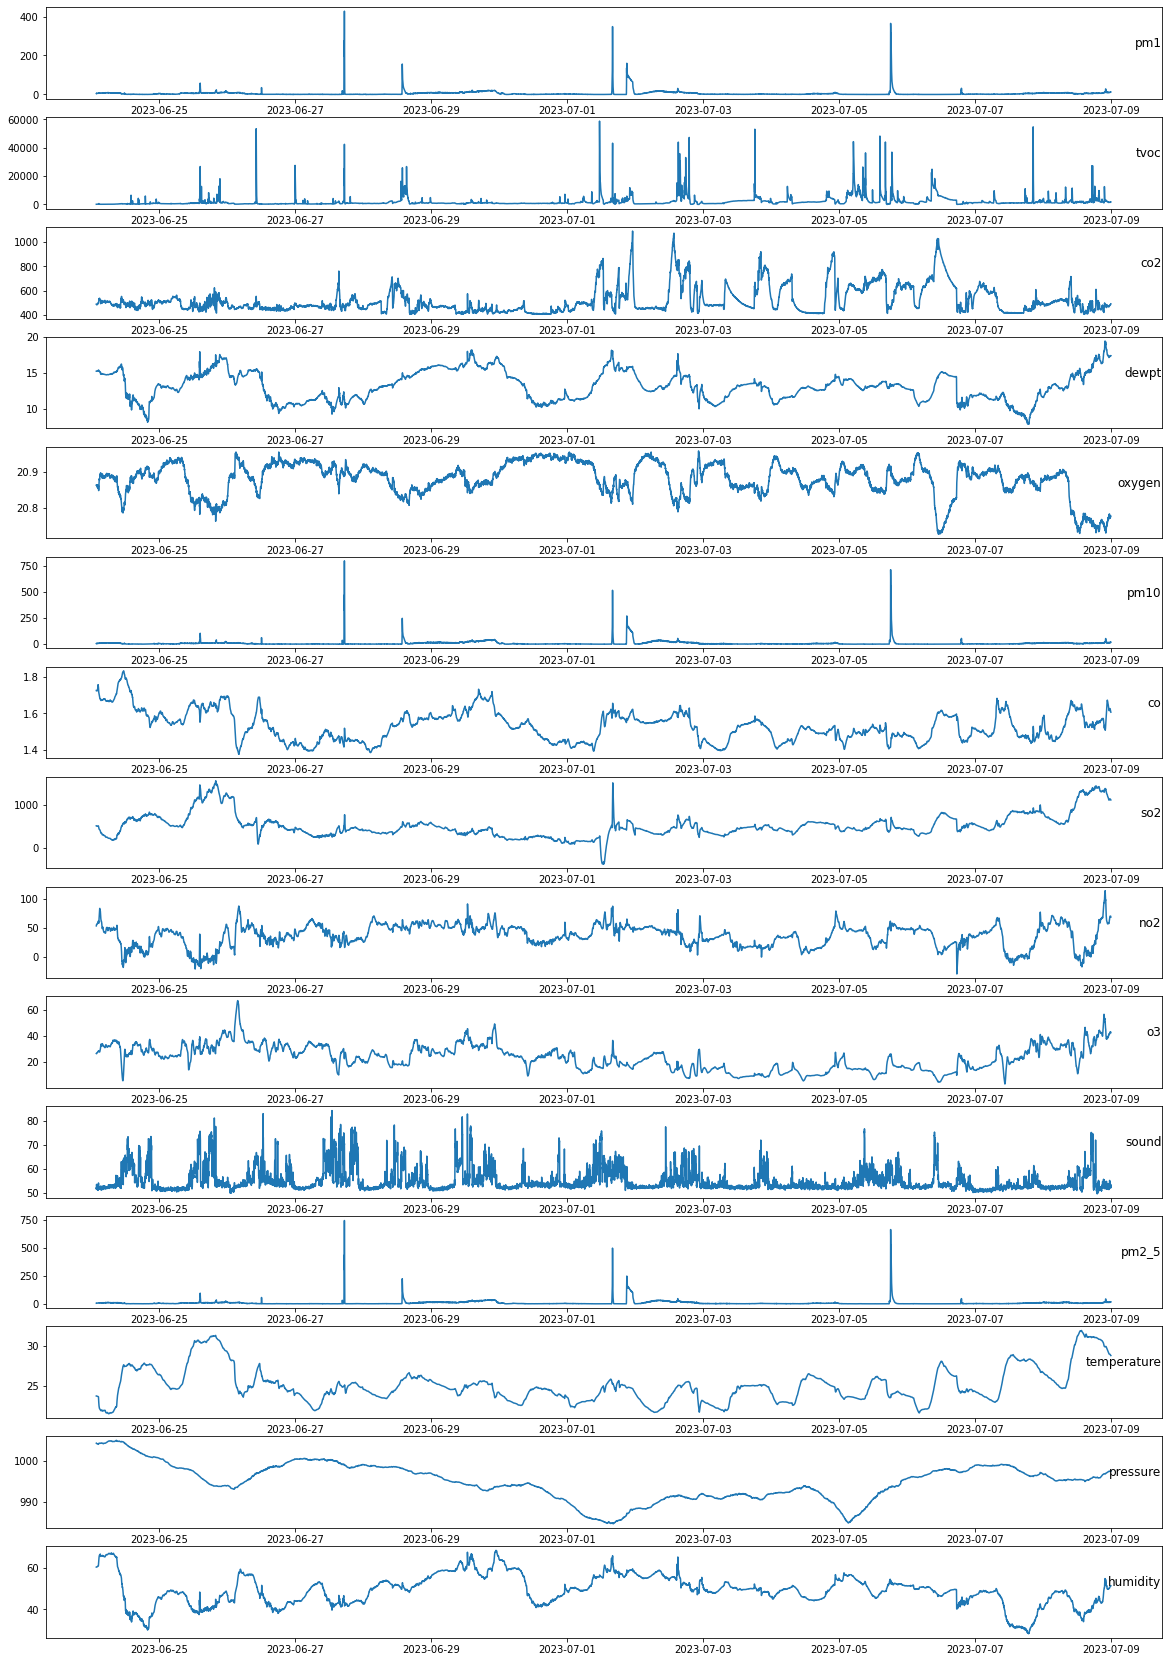

In [11]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9, 10, 11, 12, 13, 14]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

**Multivariate LSTM Predictive Modeling**

In [12]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


Les données de la série temporelle sont converties en données d'apprentissage supervisé et des étiquettes sont générées. Les variables d'entrée sont ensuite normalisées. Compte tenu des mesures de la pollution et des conditions météorologiques de l'heure précédente (t-1), nous posons le problème de l'apprentissage supervisé pour prédire la concentration de la pollution à l'heure actuelle (t).

In [13]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    agg = pd.concat(cols, axis=1)
    agg.columns = names


    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [14]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.drop(reframed.columns[[0, 1, 2, 3]], axis=1, inplace=True)
reframed.head()

,var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
1,0.588753,0.007486,0.763676,0.459352,0.577556,0.365211,0.068824,0.007231,0.213425,0.966908,...,0.121795,0.636977,0.588753,0.008592,0.763676,0.460102,0.586407,0.363713,0.076055,0.008636
2,0.588753,0.008592,0.763676,0.460102,0.586407,0.363713,0.076055,0.008636,0.213135,0.965919,...,0.119705,0.636631,0.588753,0.009334,0.763676,0.459968,0.592357,0.362262,0.053790,0.008175
3,0.588753,0.009334,0.763676,0.459968,0.592357,0.362262,0.053790,0.008175,0.213232,0.964931,...,0.118399,0.638362,0.584419,0.007324,0.763676,0.459262,0.594817,0.363978,0.114010,0.007348
4,0.584419,0.007324,0.763676,0.459262,0.594817,0.363978,0.114010,0.007348,0.213521,0.963943,...,0.114310,0.638016,0.593079,0.008813,0.761488,0.458021,0.596183,0.365070,0.081542,0.009000
5,0.593079,0.008813,0.761488,0.458021,0.596183,0.365070,0.081542,0.009000,0.212846,0.962955,...,0.112774,0.637930,0.593079,0.008857,0.759300,0.457025,0.597494,0.367301,0.067623,0.007897


80% train - 20% test
Ligne de départ de l'ensemble de données de test = train_x.shape[0]+1(onglet)+x(projetée)+1(test)
（2023-06-24 02:01:10<3> - 2023-07-06 00:18:22<8559>）         （2023-07-06 00:20:20<8560> - 2023-07-08 23:58:27<10698>）

In [15]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)
train = reframed.iloc[:train_samples, :]
test = reframed.iloc[train_samples:, :]

train_X, train_y = train.iloc[:, :-12].values, train.iloc[:, -12:].values
test_X, test_y = test.iloc[:, :-12].values, test.iloc[:, -12:].values

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8557, 1, 11) (8557, 12) (2139, 1, 11) (2139, 12)


Define the LSTM model

Il y a 50 neurones dans la première couche cachée et 11 neurones dans la couche de sortie pour prédire la concentration de pollution. La dimension des données d'entrée sera de 1 pas de temps (c'est-à-dire 2 secondes) et de 14 caractéristiques.

In [16]:
model = Sequential()
model.add(SimpleRNN(units = 50, activation='tanh', input_shape= (train_X.shape[1],train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(units = 12))
model.compile(optimizer='adam', loss='mae')
print(model.summary())
# model = Sequential()
# model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(11))
# model.compile(optimizer='adam', loss='mae')
# model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                3100      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 12)                612       
Total params: 3,712
Trainable params: 3,712
Non-trainable params: 0
_________________________________________________________________
None


Training the LSTM model

Epoch 1/400
119/119 - 0s - loss: 0.1701 - val_loss: 0.1142
Epoch 2/400
119/119 - 0s - loss: 0.1088 - val_loss: 0.0888
Epoch 3/400
119/119 - 0s - loss: 0.0844 - val_loss: 0.0707
Epoch 4/400
119/119 - 0s - loss: 0.0725 - val_loss: 0.0574
Epoch 5/400
119/119 - 0s - loss: 0.0639 - val_loss: 0.0485
Epoch 6/400
119/119 - 0s - loss: 0.0574 - val_loss: 0.0422
Epoch 7/400
119/119 - 0s - loss: 0.0523 - val_loss: 0.0393
Epoch 8/400
119/119 - 0s - loss: 0.0488 - val_loss: 0.0378
Epoch 9/400
119/119 - 0s - loss: 0.0461 - val_loss: 0.0395
Epoch 10/400
119/119 - 0s - loss: 0.0436 - val_loss: 0.0369
Epoch 11/400
119/119 - 0s - loss: 0.0419 - val_loss: 0.0376
Epoch 12/400
119/119 - 0s - loss: 0.0404 - val_loss: 0.0377
Epoch 13/400
119/119 - 0s - loss: 0.0393 - val_loss: 0.0379
Epoch 14/400
119/119 - 0s - loss: 0.0392 - val_loss: 0.0372
Epoch 15/400
119/119 - 0s - loss: 0.0389 - val_loss: 0.0368
Epoch 16/400
119/119 - 0s - loss: 0.0395 - val_loss: 0.0386
Epoch 17/400
119/119 - 0s - loss: 0.0387 - val_lo

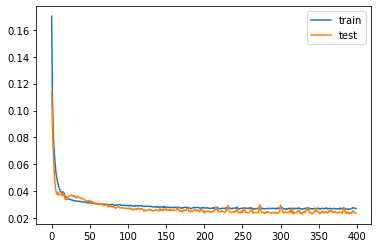

In [17]:
# history = model.fit(train_X, train_y, epochs=500, batch_size=300, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show()
history = model.fit(train_X, train_y, epochs=400, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Evaluating LSTM models

Les prédictions de sortie sont obtenues grâce au modèle, puis les valeurs réelles sont obtenues à partir des données d'origine.

In [18]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
selected_columns = [i for i in range(test_X.shape[1]) if i in [7, 8, 9]]
# selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [3, 10, 11]]
inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:-3]
# oxygen_predict = inv_yhat[:, 0]
# pm10_predict = inv_yhat[:, 1]
# co_predict = inv_yhat[:, 2]
# co2_predict = inv_yhat[:, 3]
# so2_predict = inv_yhat[:, 4]
# no2_predict = inv_yhat[:, 5]
# pm1_predict = inv_yhat[:, 6]
# dewpt_predict = inv_yhat[:, 7]
# tvoc_predict = inv_yhat[:, 8]
# pm2_5_predict = inv_yhat[:, 9]

test_y = test_y.reshape((len(test_y), train_y.shape[1]))
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())
# oxygen_reel = inv_y[:, 0]
# pm10_reel = inv_y[:, 1]
# co_reel = inv_y[:, 2]
# co2_reel = inv_y[:, 3]
# so2_reel = inv_y[:, 4]
# no2_reel = inv_y[:, 5]
# pm1_reel = inv_y[:, 6]
# dewpt_reel = inv_y[:, 7]
# tvoc_reel = inv_y[:, 8]
# pm2_5_reel = inv_y[:, 9]

# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)


      0            1           2          3          4      5      6   \
0  0.326  1159.930054  661.971008  12.763999  20.881001  1.002  1.479   
1  0.069  1146.650024  651.153992  12.744000  20.881001  0.485  1.479   
2  0.252  1146.369995  653.598999  12.749000  20.879999  0.378  1.478   
3  0.438  1163.060059  665.013977  12.745001  20.879999  0.836  1.478   
4  0.465  1190.010010  668.629028  12.740999  20.879000  0.734  1.478   

           7          8       9          10     11  
0  438.337982  47.824005  15.432  52.966000  0.699  
1  437.725983  47.506008  15.361  52.457001  0.118  
2  435.914001  47.601002  15.342  52.323002  0.336  
3  435.846954  47.555004  15.323  51.528999  0.527  
4  436.254974  47.664001  15.343  51.537998  0.502  


Afficher valeur pic sur tvoc

Comme je veux trouver la relation entre les paramètres, je vais choisir des valeurs de pic pour découvrir la relation entre les paramètres. Mais cela semble lourd et difficile à observer, nous utilisons la méthode de la carte thermique pour y parvenir.

In [19]:
# col_index = 8
# col_values = inv_y_df.iloc[:, col_index]

# filtered_rows = col_values[col_values > 8000]
# date_indices = filtered_rows.index + train_X.shape[0] + 1
# datepic = data.iloc[date_indices, col_index]
# for index, value in filtered_rows.items():
#     print(f"nb de ligne: {index}, valeur: {value}, dates: {datepic}\n")

Comparaison des valeurs prédites et des valeurs réelles pour 12 valeurs de sortie

In [20]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


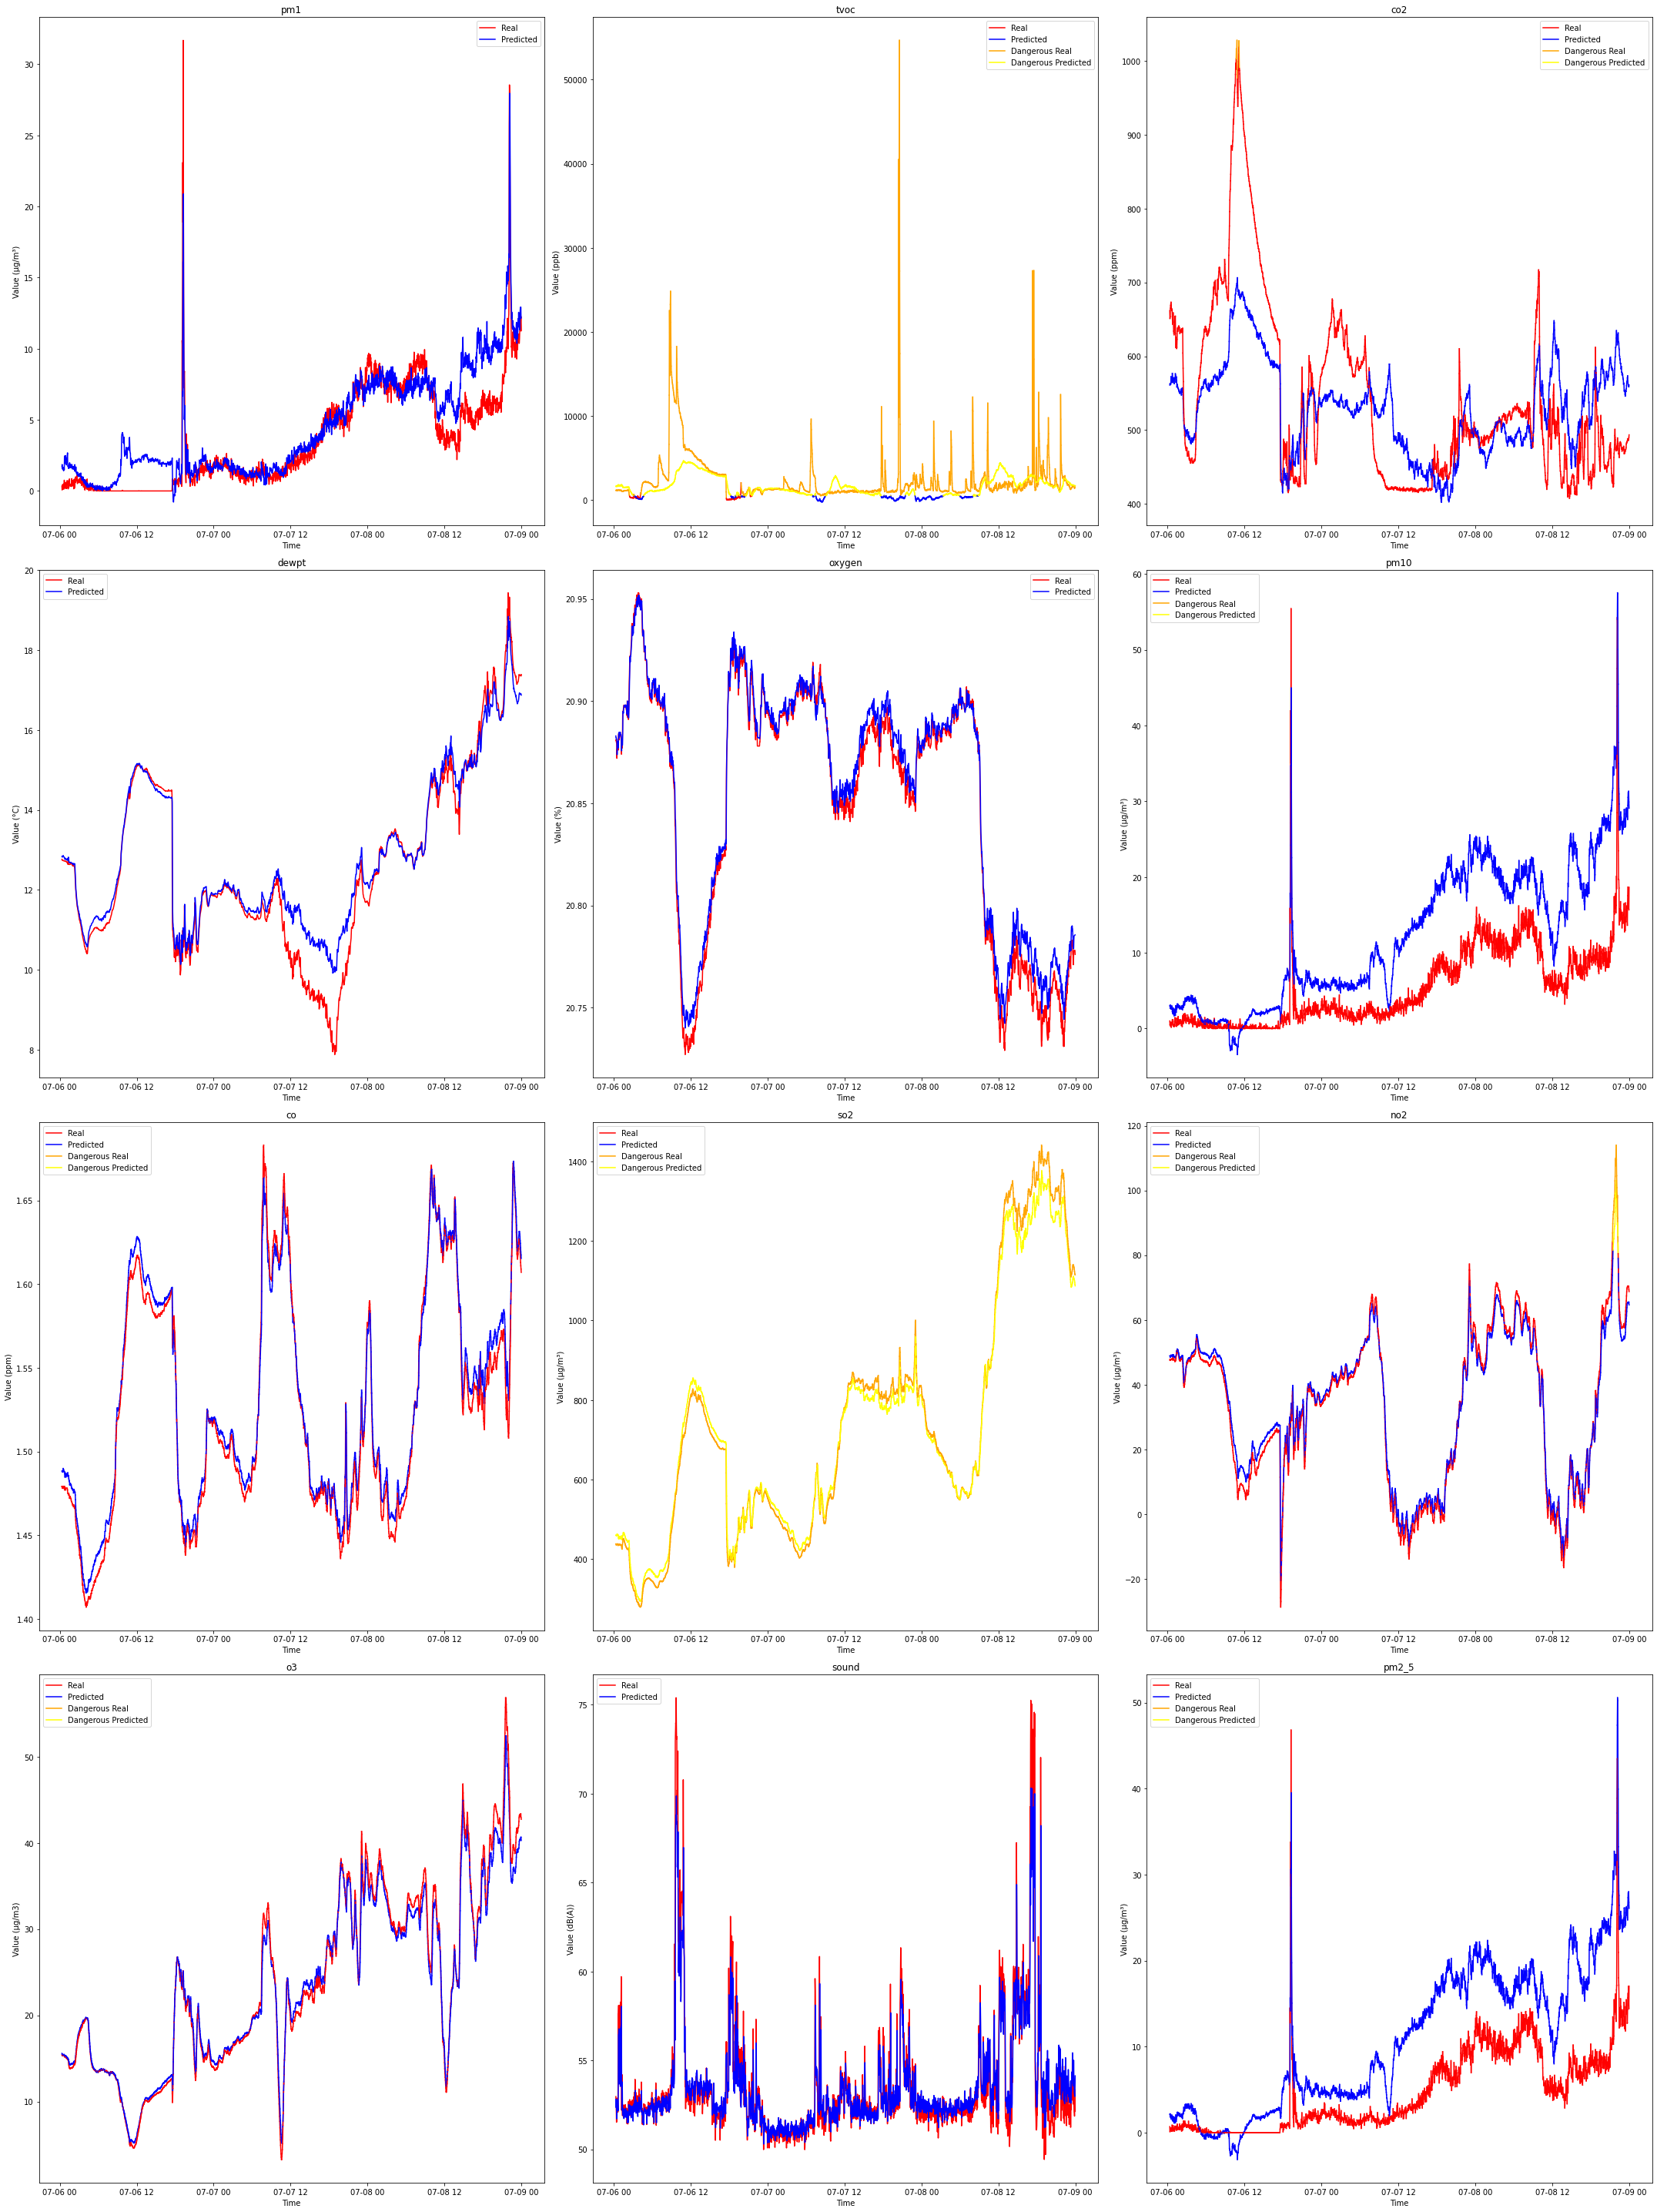

In [21]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'pm1': 0, 'tvoc': 1, 'co2': 2, 'dewpt': 3, 'oxygen': 4,
    'pm10': 5, 'co': 6, 'so2': 7, 'no2': 8, 'o3' : 9,
    'sound': 10, 'pm2_5': 11
}

feature_units = {
    'pm1': 'µg/m³', 'tvoc': 'ppb',
    'co2': 'ppm',  'dewpt': '°C', 'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³',
    'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()

Calcul de l'RMSE(Root Mean Square Error)

In [22]:

print(inv_y.shape, inv_yhat.shape)
selected_columns2 = [i for i in range(test_y.shape[1]) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
feature_names = ['pm1','tvoc','co2','dewpt','oxygen', 'pm10', 'co', 'so2', 'no2', 'o3' ,'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    # # Avoid division by zero for MAPE
    # actual_values = inv_y[:, i]
    # predicted_values = inv_yhat[:, i]
    # # Replace zeros in actual values with a small number (1e-10)
    # actual_values = np.where(actual_values == 0, 1e-10, actual_values)
    # mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    print(f'Test RMSE for {feature}: {rmse:.3f}')
    # print(f'Rest MAPE for {feature}: {mape:.3f}%')

(2139, 12) (2139, 12)
Test RMSE for pm1: 1.844
Test RMSE for tvoc: 3158.292
Test RMSE for co2: 86.750
Test RMSE for dewpt: 0.581
Test RMSE for oxygen: 0.008
Test RMSE for pm10: 8.417
Test RMSE for co: 0.008
Test RMSE for so2: 28.969
Test RMSE for no2: 3.082
Test RMSE for o3: 1.193
Test RMSE for sound: 1.468
Test RMSE for pm2_5: 7.590


In [23]:
# iaqi_condition_withouto3 = lambda x: (x[:, 6] <= 10) & (x[:, 11] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300)
# iaqi_condition = lambda x: (x[:, 6] <= 10) & (x[:, 10] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300) & (x[:, 9] < 18)
# inv_y_iaq = iaqi_condition_withouto3(inv_y).astype(int)
# inv_yhat_iaq = iaqi_condition_withouto3(inv_yhat).astype(int)
# inv_y_iaq2 = iaqi_condition(inv_y).astype(int)
# inv_yhat_iaq2 = iaqi_condition(inv_yhat).astype(int)

# inv_y = np.hstack((inv_y, inv_y_iaq.reshape(-1, 1)))
# inv_yhat = np.hstack((inv_yhat, inv_yhat_iaq.reshape(-1, 1)))
# inv_y2 = np.hstack((inv_y, inv_y_iaq2.reshape(-1, 1)))
# inv_yhat2 = np.hstack((inv_yhat, inv_yhat_iaq2.reshape(-1, 1)))

In [24]:
# print("inv_y:\n", inv_y)
# print("inv_yhat:\n", inv_yhat)

PM2.5 (Particulate Matter 2.5-micrometer)

PM2.5 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [25]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 11]
inv_y_PM25_values = inv_y[:, 11]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

PM10 (Particulate Matter 10-micrometer)

PM10 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [26]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 5]
inv_y_PM10_values = inv_y[:, 5]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

SO2 (Sulphur Dioxide)

SO2 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [27]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 7]
inv_y_SO2_values = inv_y[:, 7]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

NO2 (Any Nitric x-oxide)

NO2 is measured in ppb (parts per billion). The predefined groups are defined in the function below:

In [28]:
## NO2 Sub-Index calculation
def ugm3_to_ppb(no2_ugm3):
    MW_NO2 = 46.0055  # g/mol
    standard_volume = 24.45  # L/mol
    return (no2_ugm3 * standard_volume) / MW_NO2

def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 8]
inv_y_NO2_values = inv_y[:, 8]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

CO (Carbon Monoxide)

CO is measured in mg / m3 (milligrams per cubic meter of air). The predefined groups are defined in the function below:

In [29]:
def ppm_to_mgm3(co_ppm):
    MW_CO = 28.01  # g/mol
    standard_volume = 24.45  # L/mol
    return co_ppm * MW_CO / standard_volume
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 6]
inv_y_CO_values = inv_y[:, 6]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

O3 (Ozone or Trioxygen)

O3 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [30]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 9]
inv_y_O3_values = inv_y[:, 9]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

AQI

The final AQI is the maximum Sub-Index among the available sub-indices with the condition that at least one of PM2.5 and PM10 should be available and at least three out of the seven should be available.

There is no theoretical upper value of AQI but its rare to find values over 1000.

In [31]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 12
PM10_SubIndex_col = 13
SO2_SubIndex_col = 14
NO2_SubIndex_col = 15
CO_SubIndex_col = 16
O3_SubIndex_col = 17

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

       col0         col1        col2       col3       col4      col5  \
0  1.703299  1624.533447  560.883911  12.839774  20.882944  2.995266   
1  1.861243  1653.022095  562.626587  12.836720  20.881989  3.049142   
2  1.548162  1635.947388  561.895020  12.819817  20.882059  2.665705   
3  1.564946  1645.425659  562.775208  12.829707  20.881180  2.724571   
4  1.570911  1630.227905  561.525330  12.829482  20.881224  3.067332   

       col6        col7       col8       col9  ...     col11     col12  \
0  1.488258  460.270966  48.926857  15.584864  ...  2.124651  3.541085   
1  1.488246  459.891235  48.780151  15.534836  ...  2.175120  3.625200   
2  1.488353  459.798279  48.495712  15.477038  ...  1.822021  3.036701   
3  1.487690  458.720459  48.637394  15.451989  ...  1.853324  3.088873   
4  1.487896  459.459564  48.597183  15.438711  ...  2.133352  3.555587   

      col13       col14      col15      col16      col17  AQI_calculated  \
0  2.995266  219.112135  32.503224  85.247641 

In [32]:

from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.8532024310425432


In [33]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 


1825


anticiper

In [34]:
# 7*2 = 14 min
n_temps = 7
n_features = 15

reframed = series_to_supervised(scaled, n_temps, 1)

In [35]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.drop(reframed.columns[[0, 1, 2, 3]], axis=1, inplace=True)
reframed.head(10)

,var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),var11(t-7),var12(t-7),var13(t-7),var14(t-7),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
7,0.588753,0.007486,0.763676,0.459352,0.577556,0.365211,0.068824,0.007231,0.213425,0.966908,...,0.115279,0.638189,0.588753,0.008789,0.757112,0.454809,0.596099,0.370624,0.079570,0.008455
8,0.588753,0.008592,0.763676,0.460102,0.586407,0.363713,0.076055,0.008636,0.213135,0.965919,...,0.115752,0.639488,0.593079,0.009619,0.759300,0.454247,0.596541,0.373339,0.056076,0.009624
9,0.588753,0.009334,0.763676,0.459968,0.592357,0.362262,0.053790,0.008175,0.213232,0.964931,...,0.119245,0.640353,0.593079,0.008591,0.761488,0.454146,0.598910,0.373994,0.078770,0.008112
10,0.584419,0.007324,0.763676,0.459262,0.594817,0.363978,0.114010,0.007348,0.213521,0.963943,...,0.119999,0.639314,0.593079,0.009048,0.761488,0.454584,0.599891,0.374384,0.068967,0.009314
11,0.593079,0.008813,0.761488,0.458021,0.596183,0.365070,0.081542,0.009000,0.212846,0.962955,...,0.121418,0.640180,0.562775,0.007789,0.768053,0.455741,0.601804,0.376053,0.074111,0.008089
12,0.593079,0.008857,0.759300,0.457025,0.597494,0.367301,0.067623,0.007897,0.212171,0.961475,...,0.125503,0.640613,0.562775,0.009407,0.772429,0.456684,0.604957,0.379095,0.056819,0.009522
13,0.593079,0.008218,0.759300,0.455760,0.596975,0.369095,0.058020,0.008322,0.212171,0.960484,...,0.123783,0.640959,0.575760,0.008095,0.776805,0.457308,0.607487,0.381638,0.062364,0.008471
14,0.588753,0.008789,0.757112,0.454809,0.596099,0.370624,0.079570,0.008455,0.212267,0.959991,...,0.132610,0.643988,0.558449,0.009595,0.781182,0.457578,0.611405,0.383354,0.045587,0.009887
15,0.593079,0.009619,0.759300,0.454247,0.596541,0.373339,0.056076,0.009624,0.212075,0.959003,...,0.134140,0.644854,0.562775,0.009814,0.783370,0.457142,0.614481,0.385710,0.059049,0.009942
16,0.593079,0.008591,0.761488,0.454146,0.598910,0.373994,0.078770,0.008112,0.212075,0.958511,...,0.131066,0.644421,0.549789,0.009958,0.792123,0.457181,0.616324,0.387675,0.071653,0.010300


In [36]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_temps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8557, 105) (8557, 12) (2133, 105) (2133, 12)


In [37]:
train_X = train_X.reshape((train_X.shape[0], n_temps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_temps, n_features))

print(test_X.shape,train_X.shape)

(2133, 7, 15) (8557, 7, 15)


In [38]:
model = Sequential()
model.add(SimpleRNN(units = 50, activation='tanh', input_shape= (train_X.shape[1],train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(units = 12))
model.compile(optimizer='adam', loss='mae')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 50)                3300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                612       
Total params: 3,912
Trainable params: 3,912
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/400
119/119 - 0s - loss: 0.2035 - val_loss: 0.1319
Epoch 2/400
119/119 - 0s - loss: 0.1152 - val_loss: 0.0773
Epoch 3/400
119/119 - 0s - loss: 0.0873 - val_loss: 0.0545
Epoch 4/400
119/119 - 0s - loss: 0.0743 - val_loss: 0.0485
Epoch 5/400
119/119 - 0s - loss: 0.0638 - val_loss: 0.0400
Epoch 6/400
119/119 - 0s - loss: 0.0564 - val_loss: 0.0369
Epoch 7/400
119/119 - 0s - loss: 0.0516 - val_loss: 0.0383
Epoch 8/400
119/119 - 0s - loss: 0.0466 - val_loss: 0.0364
Epoch 9/400
119/119 - 0s - loss: 0.0441 - val_loss: 0.0350
Epoch 10/400
119/119 - 0s - loss: 0.0410 - val_loss: 0.0309
Epoch 11/400
119/119 - 0s - loss: 0.0384 - val_loss: 0.0296
Epoch 12/400
119/119 - 0s - loss: 0.0371 - val_loss: 0.0272
Epoch 13/400
119/119 - 0s - loss: 0.0361 - val_loss: 0.0283
Epoch 14/400
119/119 - 0s - loss: 0.0351 - val_loss: 0.0305
Epoch 15/400
119/119 - 0s - loss: 0.0350 - val_loss: 0.0280
Epoch 16/400
119/119 - 0s - loss: 0.0342 - val_loss: 0.0275
Epoch 17/400
119/119 - 0s - loss: 0.0336 - val_lo

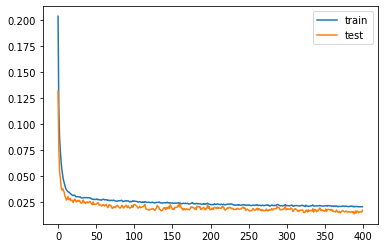

In [39]:
history = model.fit(train_X, train_y, epochs=400, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [40]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_temps*n_features))

selected_columns = [i for i in range(test_y.shape[1]) if i in [7,8,9]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:-3]
# inv_yhat = inv_yhat[:, selected_columns2]

test_y = test_y.reshape(len(test_y), test_y.shape[1])
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())

      0            1           2       3          4      5      6   \
0  0.314  1169.959961  673.091980  12.733  20.875999  0.494  1.478   
1  0.128  1145.729980  669.117004  12.730  20.877001  0.174  1.479   
2  0.289  1137.619995  663.067993  12.728  20.877001  0.389  1.478   
3  0.502  1132.069946  661.744019  12.729  20.879000  0.780  1.478   
4  0.136  1165.359985  663.919983  12.725  20.878000  0.492  1.478   

           7          8       9          10     11  
0  438.166992  47.861004  15.370  52.881001  0.491  
1  437.809021  47.721004  15.375  52.095001  0.174  
2  437.946014  47.740005  15.366  52.841000  0.389  
3  438.044983  47.889004  15.388  52.228001  0.558  
4  436.010010  47.858002  15.355  52.105000  0.172  


In [41]:
# col_index = 8
# col_values = inv_y_df.iloc[:, col_index]

# date_indices = filtered_rows.index + train_X.shape[0] + 1
# datepic = data.iloc[date_indices, col_index]
# for index, value in filtered_rows.items():
#     print(f"nb de ligne: {index}, valeur: {value}, dates: {datepic}\n")

In [42]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


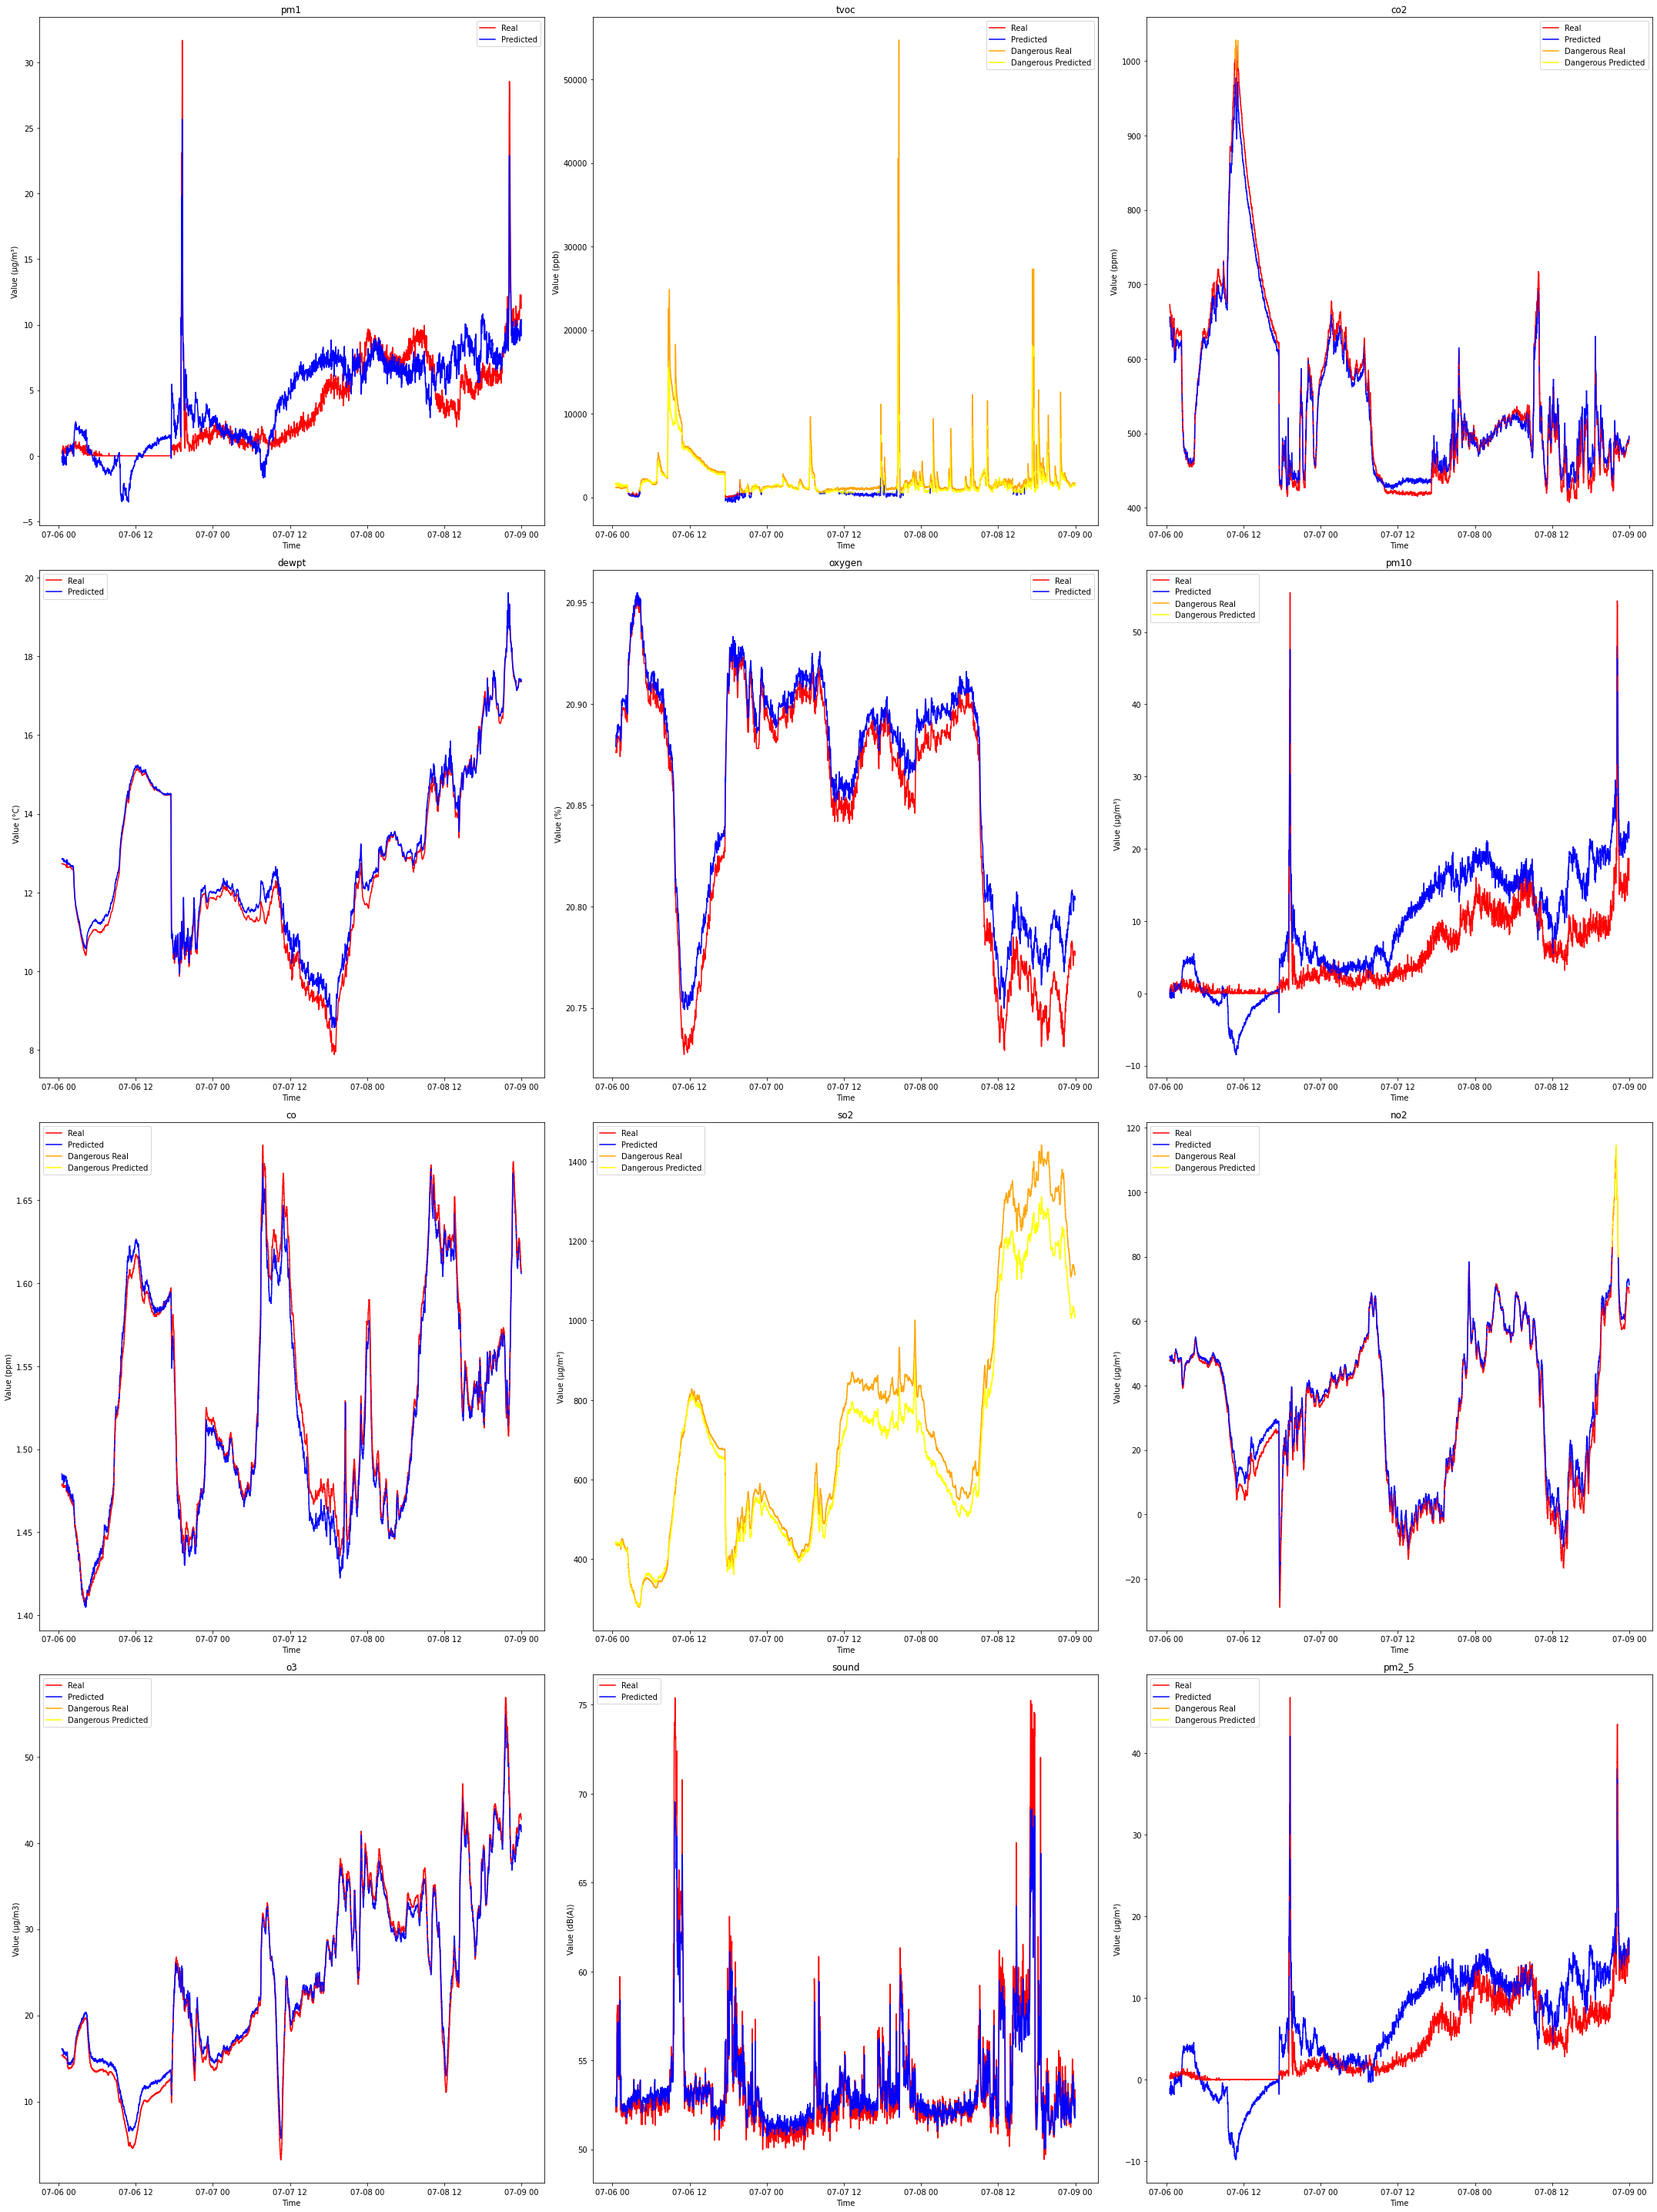

In [43]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'pm1': 0, 'tvoc': 1, 'co2': 2, 'dewpt': 3, 'oxygen': 4,
    'pm10': 5, 'co': 6, 'so2': 7, 'no2': 8, 'o3' : 9,
    'sound': 10, 'pm2_5': 11
}

feature_units = {
    'pm1': 'µg/m³', 'tvoc': 'ppb',
    'co2': 'ppm',  'dewpt': '°C', 'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³',
    'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}


for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()


L'ensemble de tests commence par des données de comptage à la ligne 9393

In [44]:
print(inv_y.shape, inv_yhat.shape)

(2133, 12) (2133, 12)


In [45]:
selected_columns2 = [i for i in range(inv_y.shape[1]) if i not in [12,13,14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]

In [46]:
feature_names = ['pm1','tvoc','co2','dewpt','oxygen', 'pm10', 'co', 'so2', 'no2', 'o3' ,'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    # mape = np.mean(np.abs((inv_y[:, i] - inv_yhat[:, i])/inv_y[:, i]))*100
    print(f'Test RMSE for {feature}: {rmse:.3f}')
    # print(f'Rest MAPE for {feature}: {mape:.3f}%')

Test RMSE for pm1: 2.042
Test RMSE for tvoc: 1304.415
Test RMSE for co2: 15.403
Test RMSE for dewpt: 0.268
Test RMSE for oxygen: 0.015
Test RMSE for pm10: 5.469
Test RMSE for co: 0.009
Test RMSE for so2: 66.095
Test RMSE for no2: 2.797
Test RMSE for o3: 0.969
Test RMSE for sound: 1.498
Test RMSE for pm2_5: 3.947


In [47]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 11]
inv_y_PM25_values = inv_y[:, 11]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

In [48]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 5]
inv_y_PM10_values = inv_y[:, 5]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

In [49]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 7]
inv_y_SO2_values = inv_y[:, 7]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

In [50]:
## NO2 Sub-Index calculation
def ugm3_to_ppb(no2_ugm3):
    MW_NO2 = 46.0055  # g/mol
    standard_volume = 24.45  # L/mol
    return (no2_ugm3 * standard_volume) / MW_NO2

def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 8]
inv_y_NO2_values = inv_y[:, 8]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

In [51]:
def ppm_to_mgm3(co_ppm):
    MW_CO = 28.01  # g/mol
    standard_volume = 24.45  # L/mol
    return co_ppm * MW_CO / standard_volume
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 6]
inv_y_CO_values = inv_y[:, 6]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

In [52]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 9]
inv_y_O3_values = inv_y[:, 9]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

In [53]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 12
PM10_SubIndex_col = 13
SO2_SubIndex_col = 14
NO2_SubIndex_col = 15
CO_SubIndex_col = 16
O3_SubIndex_col = 17

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

       col0         col1        col2       col3       col4      col5  \
0 -0.098959  1682.717041  656.202881  12.856482  20.878887  0.059029   
1 -0.503308  1472.640625  650.270813  12.865074  20.883766 -0.520205   
2 -0.156176  1490.793945  643.976135  12.853595  20.884710  0.016236   
3 -0.001588  1586.285767  643.535217  12.835699  20.884109  0.299273   
4 -0.387590  1544.567749  646.950684  12.845682  20.885735 -0.353339   

       col6        col7       col8       col9  ...     col11     col12  \
0  1.485138  444.115784  49.021496  16.122040  ... -1.081619 -1.802698   
1  1.481840  438.174591  48.713066  16.125740  ... -1.649548 -2.749247   
2  1.484000  439.136963  48.430588  16.012032  ... -1.093610 -1.822683   
3  1.481684  440.166504  48.774723  15.974998  ... -0.824972 -1.374954   
4  1.482232  439.921906  49.017975  16.026987  ... -1.455769 -2.426282   

      col13       col14      col15      col16      col17  AQI_calculated  \
0  0.059029  215.265663  32.566095  85.068951 

In [54]:
# print("inv_y:\n", inv_y)
# print("inv_yhat:\n", inv_yhat)

In [55]:
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.8406000937646507


In [56]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 

1793
